# Healthcare Assistant via LLM Fine-Tuning

## Project Overview
This notebook fine-tunes **TinyLlama-1.1B-Chat** on medical flashcard Q&A data to create a domain-specific healthcare assistant.

**Domain**: Healthcare (Medical Question Answering)  
**Problem**: General LLMs lack specialized medical knowledge for accurate healthcare Q&A  
**Solution**: Fine-tune TinyLlama on medical flashcards using LoRA for domain-specific accuracy

**Key Features:**
- **Domain**: Healthcare (Medical Q&A)
- **Model**: TinyLlama/TinyLlama-1.1B-Chat-v1.0 (1.1B parameters)
- **Dataset**: medalpaca/medical_meadow_medical_flashcards (10,178 samples)
- **Method**: LoRA (Low-Rank Adaptation) via PEFT library
- **Platform**: Google Colab (Free T4 GPU)
- **Training Samples**: 2,000 (validation: 200)

**Assignment Goals:**
1. Fine-tune a generative LLM for healthcare domain

2. Implement parameter-efficient training (LoRA + 4-bit quantization)6. Document 3 hyperparameter experiments

3. Evaluate with NLP metrics (BLEU, ROUGE, perplexity)5. Deploy with Gradio UI
4. Compare base vs fine-tuned model

---
## 1. Environment Setup & Dependencies

In [ ]:
# Check environment and GPU
import sys
import torch

print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")

# Verify we're in Colab
try:
    import google.colab
    print("[OK] Running in Google Colab")
except:
    print("[WARNING] Not running in Google Colab. This notebook is optimized for Colab.")

# Check GPU
if torch.cuda.is_available():
    print(f"[OK] GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("[INFO] No GPU detected. Training will use CPU (slower).")
    print("   Recommendation: Enable GPU in Runtime > Change runtime type > Hardware accelerator > T4 GPU")

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch version: 2.10.0+cu128
[OK] Running in Google Colab
[OK] GPU Available: Tesla T4
  GPU Memory: 15.64 GB


In [ ]:
# Install required packages for Colab
print("Installing dependencies...\n")

!pip install -q -U datasets transformers accelerate peft bitsandbytes
!pip install -q -U evaluate rouge-score sacrebleu gradio

print("\n[OK] All packages installed successfully!")

Installing dependencies...


[OK] All packages installed successfully!


In [ ]:
import subprocess, sys
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "--force-reinstall", "-q", "pyarrow"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "-q", "datasets"])
print("[OK] Fixed!")

[OK] Fixed!


In [ ]:
# FIX: Aggressive PyArrow & Datasets compatibility resolver
import subprocess
import sys

print("="*70)
print("AGGRESSIVE FIX: Resolving PyArrow binary compatibility issue...")
print("="*70)

# Step 1: Clear pip cache
print("\n[Step 1] Clearing pip cache...")
subprocess.run([sys.executable, "-m", "pip", "cache", "purge"], capture_output=True)
print("✓ Cache cleared")

# Step 2: Completely uninstall problematic packages
print("\n[Step 2] Uninstalling conflicting packages...")
for package in ["pyarrow", "datasets", "transformers", "huggingface-hub"]:
    subprocess.run(
        [sys.executable, "-m", "pip", "uninstall", "-y", package],
        capture_output=True
    )
print("✓ Packages removed")

# Step 3: Reinstall with compatible versions
print("\n[Step 3] Installing compatible versions...")
packages_to_install = [
    "pyarrow==14.0.1",  # Specific stable version
    "datasets>=2.17.0",
    "huggingface-hub>=0.20.0",
    "transformers>=4.36.0"
]

for package in packages_to_install:
    print(f"  Installing {package}...")
    result = subprocess.run(
        [sys.executable, "-m", "pip", "install", "-q", package],
        capture_output=True,
        text=True
    )
    if result.returncode != 0:
        print(f"  ⚠ Warning: {result.stderr[:100]}")
    else:
        print(f"  ✓ {package} installed")

print("\n" + "="*70)
print("[OK] AGGRESSIVE FIX COMPLETE!")
print("="*70)
print("\n IMPORTANT: Restart the kernel now!")
print("   In Colab: Runtime > Restart runtime")
print("   In VS Code: Select Restart Kernel button")
print("\nThen run the 'Import libraries' cell after restart.")
print("="*70)

AGGRESSIVE FIX: Resolving PyArrow binary compatibility issue...

[Step 1] Clearing pip cache...
✓ Cache cleared

[Step 2] Uninstalling conflicting packages...
✓ Packages removed

[Step 3] Installing compatible versions...
  Installing pyarrow==14.0.1...
  ✓ pyarrow==14.0.1 installed
  Installing datasets>=2.17.0...
  ✓ datasets>=2.17.0 installed
  Installing huggingface-hub>=0.20.0...
  ✓ huggingface-hub>=0.20.0 installed
  Installing transformers>=4.36.0...
  ✓ transformers>=4.36.0 installed

[OK] AGGRESSIVE FIX COMPLETE!

 IMPORTANT: Restart the kernel now!
   In Colab: Runtime > Restart runtime
   In VS Code: Select Restart Kernel button

Then run the 'Import libraries' cell after restart.


In [ ]:
# Import libraries
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import evaluate
import numpy as np
import pandas as pd
import json
import time
from datetime import datetime

print("[OK] All imports successful")

[OK] All imports successful


In [ ]:
# Check device (GPU or CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"[OK] Using device: {device}")

if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Available memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("  [WARNING] Running on CPU. Training will be significantly slower.")
    print("  [RECOMMENDATION] Enable GPU: Runtime > Change runtime type > T4 GPU")

[OK] Using device: cuda
  GPU: Tesla T4
  Available memory: 15.64 GB


---
## 2. Dataset Loading & Exploration

In [ ]:
# Load the medical flashcards dataset
print("Loading dataset: medalpaca/medical_meadow_medical_flashcards")
dataset = load_dataset("medalpaca/medical_meadow_medical_flashcards")

print("\nDataset structure:")
print(dataset)

Loading dataset: medalpaca/medical_meadow_medical_flashcards

Dataset structure:
DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})


In [ ]:
# Explore dataset
print("Dataset info:")
print(f"Total samples: {len(dataset['train'])}")
print(f"\nColumns: {dataset['train'].column_names}")
print(f"\nFirst 3 examples:")

for i in range(3):
    example = dataset['train'][i]
    print(f"\n--- Example {i+1} ---")
    for key, value in example.items():
        print(f"{key}: {value[:200] if isinstance(value, str) and len(value) > 200 else value}")

Dataset info:
Total samples: 33955

Columns: ['input', 'output', 'instruction']

First 3 examples:

--- Example 1 ---
input: What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
output: Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.
instruction: Answer this question truthfully

--- Example 2 ---
input: What leads to genitourinary syndrome of menopause (atrophic vaginitis)?
output: Low estradiol production leads to genitourinary syndrome of menopause (atrophic vaginitis).
instruction: Answer this question truthfully

--- Example 3 ---
input: What does low REM sleep latency and experiencing hallucinations/sleep paralysis suggest?
output: Low REM sleep latency and experiencing hallucinations/sleep paralysis suggests narcolepsy.
instruction: Answer this question truthfully


Text length statistics:
Mean: 441.50 characters
Median: 265.00 characters
Max: 1689 characters
Min: 0 characters


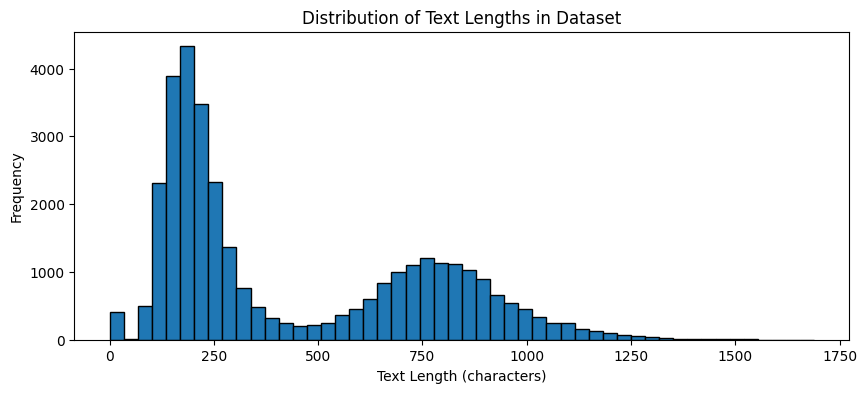

In [ ]:
# Analyze dataset statistics
import matplotlib.pyplot as plt

# Get all text lengths
text_lengths = []
for item in dataset['train']:
    # Adjust field name based on actual dataset structure
    if 'input' in item and 'output' in item:
        text_lengths.append(len(item['input']) + len(item['output']))
    elif 'instruction' in item and 'output' in item:
        text_lengths.append(len(item['instruction']) + len(item['output']))

print(f"Text length statistics:")
print(f"Mean: {np.mean(text_lengths):.2f} characters")
print(f"Median: {np.median(text_lengths):.2f} characters")
print(f"Max: {np.max(text_lengths)} characters")
print(f"Min: {np.min(text_lengths)} characters")

# Plot distribution
plt.figure(figsize=(10, 4))
plt.hist(text_lengths, bins=50, edgecolor='black')
plt.xlabel('Text Length (characters)')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths in Dataset')
plt.show()

---
## 3. Data Preprocessing & Formatting

In [ ]:
# Define prompt template for instruction-following format
def create_prompt_template(instruction, response=""):
    """
    Create a chat-style prompt for TinyLlama.
    Format: <|system|>\n{system_message}\n<|user|>\n{instruction}\n<|assistant|>\n{response}
    """
    system_message = "You are a helpful medical assistant. Provide accurate and concise answers to medical questions."

    if response:
        # Training format (with answer)
        prompt = f"""<|system|>
{system_message}
<|user|>
{instruction}
<|assistant|>
{response}"""
    else:
        # Inference format (without answer)
        prompt = f"""<|system|>
{system_message}
<|user|>
{instruction}
<|assistant|>
"""

    return prompt

# Test the template
sample = dataset['train'][0]
# Adjust field names based on actual dataset structure
instruction_field = 'input' if 'input' in sample else 'instruction'
output_field = 'output'

test_prompt = create_prompt_template(sample[instruction_field], sample[output_field])
print("Sample formatted prompt:")
print(test_prompt)
print(f"\nPrompt length: {len(test_prompt)} characters")

Sample formatted prompt:
<|system|>
You are a helpful medical assistant. Provide accurate and concise answers to medical questions.
<|user|>
What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
<|assistant|>
Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.

Prompt length: 305 characters


In [ ]:
# Load tokenizer
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
print(f"Loading tokenizer: {model_name}")

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

print(f"[OK] Tokenizer loaded")
print(f"Vocabulary size: {len(tokenizer)}")
print(f"Max length: {tokenizer.model_max_length}")

Loading tokenizer: TinyLlama/TinyLlama-1.1B-Chat-v1.0
[OK] Tokenizer loaded
Vocabulary size: 32000
Max length: 2048


In [ ]:
# Preprocess dataset
def format_dataset(examples):
    """Format dataset into instruction-response pairs."""
    # Determine field names
    sample_keys = list(examples.keys())
    instruction_field = 'input' if 'input' in sample_keys else 'instruction'
    output_field = 'output'

    prompts = []
    for i in range(len(examples[instruction_field])):
        instruction = examples[instruction_field][i]
        response = examples[output_field][i]
        prompt = create_prompt_template(instruction, response)
        prompts.append(prompt)

    return {"text": prompts}

# Apply formatting
print("Formatting dataset...")
formatted_dataset = dataset.map(
    format_dataset,
    batched=True,
    remove_columns=dataset['train'].column_names
)

print("[OK] Dataset formatted")
print(f"Sample formatted text:\n{formatted_dataset['train'][0]['text'][:500]}...")

Formatting dataset...
[OK] Dataset formatted
Sample formatted text:
<|system|>
You are a helpful medical assistant. Provide accurate and concise answers to medical questions.
<|user|>
What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?
<|assistant|>
Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels....


In [ ]:
# Tokenize dataset
def tokenize_function(examples):
    """Tokenize the formatted prompts."""
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=512,  # Limit to 512 tokens for faster training
        padding=False,
    )

print("Tokenizing dataset...")
tokenized_dataset = formatted_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=["text"]
)

print("[OK] Dataset tokenized")
print(f"Sample tokenized length: {len(tokenized_dataset['train'][0]['input_ids'])} tokens")

Tokenizing dataset...
[OK] Dataset tokenized
Sample tokenized length: 88 tokens


In [ ]:
# Split dataset: use 2000 samples for training, 200 for validation
# This balances quality with training time on free Colab
train_size = 2000
val_size = 200

if len(tokenized_dataset['train']) < train_size + val_size:
    train_size = int(len(tokenized_dataset['train']) * 0.9)
    val_size = len(tokenized_dataset['train']) - train_size

train_dataset = tokenized_dataset['train'].select(range(train_size))
eval_dataset = tokenized_dataset['train'].select(range(train_size, train_size + val_size))

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

Training samples: 2000
Validation samples: 200


---
## 4. Model Loading with LoRA Configuration

In [ ]:
# Load base model (with 4-bit quantization on GPU, full precision on CPU)
print(f"Loading base model: {model_name}")

if torch.cuda.is_available():
    print("Using 4-bit quantization for memory efficiency on GPU")
    from transformers import BitsAndBytesConfig

    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )

    # Load model with quantization
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True
    )

    # Prepare for LoRA training
    model = prepare_model_for_kbit_training(model)
    print("[OK] Model loaded with 4-bit quantization")
else:
    print("Using full precision on CPU")
    # Load model without quantization for CPU
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        trust_remote_code=True
    )
    print("[OK] Model loaded in full precision")

print(f"Model parameters: {model.num_parameters() / 1e6:.2f}M")

Loading base model: TinyLlama/TinyLlama-1.1B-Chat-v1.0
Using 4-bit quantization for memory efficiency on GPU


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

[OK] Model loaded with 4-bit quantization
Model parameters: 1100.05M


In [ ]:
# Configure LoRA
print("Configuring LoRA...")

lora_config = LoraConfig(
    r=16,  # LoRA rank (higher = more parameters, better quality but slower)
    lora_alpha=32,  # LoRA scaling factor
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj"],  # Apply LoRA to attention layers
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply LoRA to model
model = get_peft_model(model, lora_config)

# Print trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print("[OK] LoRA configured")
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M ({100 * trainable_params / total_params:.2f}%)")
print(f"Total parameters: {total_params / 1e6:.2f}M")

Configuring LoRA...
[OK] LoRA configured
Trainable parameters: 4.51M (0.73%)
Total parameters: 620.11M


---
## 5. Training Configuration & Experiments

We will run **3 experiments** with different hyperparameters to find the best configuration.

In [ ]:
# Define experiment configurations
experiments = {
    "Experiment 1: Baseline": {
        "learning_rate": 2e-4,
        "num_epochs": 1,
        "batch_size": 2,
        "gradient_accumulation_steps": 4,
        "warmup_steps": 100,
    },
    "Experiment 2: Lower LR": {
        "learning_rate": 1e-4,
        "num_epochs": 2,
        "batch_size": 2,
        "gradient_accumulation_steps": 4,
        "warmup_steps": 100,
    },
    "Experiment 3: Optimized": {
        "learning_rate": 5e-5,
        "num_epochs": 2,
        "batch_size": 4,
        "gradient_accumulation_steps": 2,
        "warmup_steps": 50,
    }
}

# Display experiments
print("Experiment Configurations:")
print("="*70)
for exp_name, config in experiments.items():
    print(f"\n{exp_name}")
    for key, value in config.items():
        print(f"  {key}: {value}")
print("="*70)

Experiment Configurations:

Experiment 1: Baseline
  learning_rate: 0.0002
  num_epochs: 1
  batch_size: 2
  gradient_accumulation_steps: 4
  warmup_steps: 100

Experiment 2: Lower LR
  learning_rate: 0.0001
  num_epochs: 2
  batch_size: 2
  gradient_accumulation_steps: 4
  warmup_steps: 100

Experiment 3: Optimized
  learning_rate: 5e-05
  num_epochs: 2
  batch_size: 4
  gradient_accumulation_steps: 2
  warmup_steps: 50


In [ ]:
# Choose experiment to run (change this to run different experiments)
CURRENT_EXPERIMENT = "Experiment 1: Baseline"  # Change to test different configs

config = experiments[CURRENT_EXPERIMENT]
print(f"Running: {CURRENT_EXPERIMENT}")
print(f"Configuration: {config}")

Running: Experiment 1: Baseline
Configuration: {'learning_rate': 0.0002, 'num_epochs': 1, 'batch_size': 2, 'gradient_accumulation_steps': 4, 'warmup_steps': 100}


In [ ]:
# Set up training arguments
output_dir = f"./results_{CURRENT_EXPERIMENT.split(':')[0].replace(' ', '_').lower()}"

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=config["num_epochs"],
    per_device_train_batch_size=config["batch_size"],
    per_device_eval_batch_size=config["batch_size"],
    gradient_accumulation_steps=config["gradient_accumulation_steps"],
    learning_rate=config["learning_rate"],
    warmup_steps=config["warmup_steps"],
    logging_steps=50,
    eval_strategy="steps",  # Changed from evaluation_strategy
    eval_steps=200,
    save_strategy="steps",
    save_steps=500,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # Use FP16 on GPU, FP32 on CPU
    optim="adamw_torch",
    report_to="none",
    load_best_model_at_end=False,
    push_to_hub=False,
)

print("[OK] Training arguments configured")

[OK] Training arguments configured


In [ ]:
# Data collator for language modeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal LM, not masked LM
)

print("[OK] Data collator ready")

[OK] Data collator ready


---
## 6. Training

In [ ]:
# Initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
)

print("[OK] Trainer initialized")
print(f"Training will start on device: {training_args.device}")

[OK] Trainer initialized
Training will start on device: cuda:0


In [ ]:
# Train the model
print(f"\n{'='*70}")
print(f"Starting training: {CURRENT_EXPERIMENT}")
print(f"{'='*70}\n")

start_time = time.time()

# Track GPU memory before training
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    memory_before = torch.cuda.memory_allocated() / 1e9

train_result = trainer.train()

training_time = time.time() - start_time

# Track GPU memory after training
if torch.cuda.is_available():
    memory_peak = torch.cuda.max_memory_allocated() / 1e9
    print(f"\n[OK] Training completed!")
    print(f"Training time: {training_time/60:.2f} minutes")
    print(f"Peak GPU memory: {memory_peak:.2f} GB")
else:
    print(f"\n[OK] Training completed!")
    print(f"Training time: {training_time/60:.2f} minutes")

# Save training metrics
metrics = train_result.metrics
print(f"\nFinal training loss: {metrics['train_loss']:.4f}")


Starting training: Experiment 1: Baseline



/usr/local/lib/python3.12/dist-packages/torch/_dynamo/eval_frame.py:1181: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. Starting in PyTorch 2.9, calling checkpoint without use_reentrant will raise an exception. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
200,0.770235,0.737767



[OK] Training completed!
Training time: 7.82 minutes
Peak GPU memory: 4.37 GB

Final training loss: 0.8886


In [ ]:
# Save the fine-tuned model
model_save_path = f"./fine_tuned_model_{CURRENT_EXPERIMENT.split(':')[0].replace(' ', '_').lower()}"
model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"[OK] Model saved to: {model_save_path}")

[OK] Model saved to: ./fine_tuned_model_experiment_1


---
## 7. Evaluation with NLP Metrics

In [ ]:
# Load evaluation metrics
bleu_metric = evaluate.load("sacrebleu")
rouge_metric = evaluate.load("rouge")

print("[OK] Evaluation metrics loaded (BLEU, ROUGE)")

[OK] Evaluation metrics loaded (BLEU, ROUGE)


In [ ]:
# Generate predictions on validation set
print("Generating predictions for evaluation...")

num_eval_samples = 50  # Evaluate on subset for speed
eval_samples = eval_dataset.select(range(min(num_eval_samples, len(eval_dataset))))

predictions = []
references = []

model.eval()
with torch.no_grad():
    for i, sample in enumerate(eval_samples):
        if i % 10 == 0:
            print(f"Processing {i}/{num_eval_samples}...")

        # Get input without the response
        input_ids = torch.tensor([sample['input_ids'][:256]]).to(model.device)  # Use first half as input

        # Generate
        outputs = model.generate(
            input_ids,
            max_new_tokens=100,
            do_sample=True,
            temperature=0.7,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

        # Decode
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        reference = tokenizer.decode(sample['input_ids'], skip_special_tokens=True)

        predictions.append(prediction)
        references.append(reference)

print("[OK] Predictions generated")

Generating predictions for evaluation...
Processing 0/50...
Processing 10/50...
Processing 20/50...
Processing 30/50...
Processing 40/50...
[OK] Predictions generated


In [ ]:
# Calculate BLEU score
bleu_results = bleu_metric.compute(
    predictions=predictions,
    references=[[ref] for ref in references]
)

# Calculate ROUGE scores
rouge_results = rouge_metric.compute(
    predictions=predictions,
    references=references
)

print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)
print(f"\nBLEU Score: {bleu_results['score']:.2f}")
print(f"\nROUGE Scores:")
print(f"  ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"  ROUGE-2: {rouge_results['rouge2']:.4f}")
print(f"  ROUGE-L: {rouge_results['rougeL']:.4f}")
print("="*70)


EVALUATION RESULTS

BLEU Score: 46.54

ROUGE Scores:
  ROUGE-1: 0.5857
  ROUGE-2: 0.5804
  ROUGE-L: 0.5856


In [ ]:
# Calculate perplexity on validation set
print("\nCalculating perplexity...")

eval_results = trainer.evaluate()
perplexity = np.exp(eval_results['eval_loss'])

print(f"Validation Loss: {eval_results['eval_loss']:.4f}")
print(f"Perplexity: {perplexity:.2f}")


Calculating perplexity...


Validation Loss: 0.7362
Perplexity: 2.09


---
## 8. Qualitative Testing & Comparison

In [ ]:
# Test questions for qualitative evaluation
test_questions = [
    "What is the treatment for pneumonia?",
    "What are the symptoms of diabetes?",
    "How is hypertension diagnosed?",
    "What causes anemia?",
    "What is the function of insulin?",
]

print("Qualitative Testing: Fine-Tuned Model")
print("="*70)

for question in test_questions:
    prompt = create_prompt_template(question, "")
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=150,
        do_sample=True,
        temperature=0.7,
        top_p=0.9,
        pad_token_id=tokenizer.eos_token_id
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the assistant's response
    if "<|assistant|>" in response:
        answer = response.split("<|assistant|>")[-1].strip()
    else:
        answer = response

    print(f"\nQ: {question}")
    print(f"A: {answer}")
    print("-"*70)

Qualitative Testing: Fine-Tuned Model

Q: What is the treatment for pneumonia?
A: The treatment for pneumonia is antibiotics. This can include a variety of different antibiotics depending on the type of pneumonia being treated. The type of antibiotic chosen will depend on the specific type of pneumonia being treated, as well as the severity of the infection. Some common antibiotics used in the treatment of pneumonia include amoxicillin, cephalexin, and azithromycin. It is important to follow the prescribed dosage and duration of treatment for pneumonia, as this can help to prevent complications and improve the outcome of treatment.
----------------------------------------------------------------------

Q: What are the symptoms of diabetes?
A: The symptoms of diabetes include polyuria, polydipsia, and polydromic symptoms. Polyuria refers to the presence of excessive urine production, which can be caused by various factors, such as excessive thirst, urinary tract infections, and kidney d

In [ ]:
# Load base model for comparison (without fine-tuning)
print("Loading base model for comparison...")

if torch.cuda.is_available():
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map="auto",
        trust_remote_code=True
    )
else:
    base_model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float32,
        trust_remote_code=True
    )

print("[OK] Base model loaded")

Loading base model for comparison...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

[OK] Base model loaded


In [ ]:
# Compare base vs fine-tuned
print("\nComparison: Base Model vs Fine-Tuned Model")
print("="*70)

comparison_question = "What is the treatment for pneumonia?"

# Base model response
prompt = create_prompt_template(comparison_question, "")
inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)

outputs_base = base_model.generate(
    **inputs,
    max_new_tokens=150,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)

response_base = tokenizer.decode(outputs_base[0], skip_special_tokens=True)
if "<|assistant|>" in response_base:
    answer_base = response_base.split("<|assistant|>")[-1].strip()
else:
    answer_base = response_base

# Fine-tuned model response
outputs_finetuned = model.generate(
    **inputs,
    max_new_tokens=150,
    do_sample=True,
    temperature=0.7,
    top_p=0.9,
    pad_token_id=tokenizer.eos_token_id
)

response_finetuned = tokenizer.decode(outputs_finetuned[0], skip_special_tokens=True)
if "<|assistant|>" in response_finetuned:
    answer_finetuned = response_finetuned.split("<|assistant|>")[-1].strip()
else:
    answer_finetuned = response_finetuned

print(f"\nQuestion: {comparison_question}")
print(f"\n--- BASE MODEL ---")
print(answer_base)
print(f"\n--- FINE-TUNED MODEL ---")
print(answer_finetuned)
print("="*70)


Comparison: Base Model vs Fine-Tuned Model

Question: What is the treatment for pneumonia?

--- BASE MODEL ---
The treatment for pneumonia is generally supportive care, which means focusing on providing comfort and keeping the patient hydrated. The following are some common treatments:

1. Antibiotics: These medications are prescribed to fight bacterial infections that may cause pneumonia.

2. Supplemental oxygen: This helps to improve oxygenation in the blood and reduce inflammation.

3. Antiviral medications: These medications are used to fight viral infections that may cause pneumonia.

4. Hydration: Keeping the patient hydrated is essential for preventing dehydration, which can w

--- FINE-TUNED MODEL ---
Antibiotics are the treatment for pneumonia. This includes penicillin, amoxicillin, and cephalosporins. These antibiotics work by killing bacteria that are causing the infection. The type of antibiotic that is used depends on the type of bacteria that is causing the infection. An

---
## 9. Experiment Tracking Table

Document all experiments and their results for the report.

In [ ]:
# Create experiment tracking table
experiment_results = {
    "Experiment": [CURRENT_EXPERIMENT],
    "Learning Rate": [config["learning_rate"]],
    "Epochs": [config["num_epochs"]],
    "Batch Size": [config["batch_size"]],
    "Gradient Accumulation": [config["gradient_accumulation_steps"]],
    "Training Loss": [f"{metrics['train_loss']:.4f}"],
    "Validation Loss": [f"{eval_results['eval_loss']:.4f}"],
    "Perplexity": [f"{perplexity:.2f}"],
    "BLEU": [f"{bleu_results['score']:.2f}"],
    "ROUGE-1": [f"{rouge_results['rouge1']:.4f}"],
    "ROUGE-L": [f"{rouge_results['rougeL']:.4f}"],
    "Training Time (min)": [f"{training_time/60:.2f}"],
}

if torch.cuda.is_available():
    experiment_results["Peak GPU Memory (GB)"] = [f"{memory_peak:.2f}"]

experiment_df = pd.DataFrame(experiment_results)

print("\nEXPERIMENT TRACKING TABLE")
print("="*100)
print(experiment_df.to_string(index=False))
print("="*100)

# Save to CSV
experiment_df.to_csv("experiment_results.csv", mode='a', header=not pd.io.common.file_exists("experiment_results.csv"), index=False)
print("\n[OK] Results saved to experiment_results.csv")


EXPERIMENT TRACKING TABLE
            Experiment  Learning Rate  Epochs  Batch Size  Gradient Accumulation Training Loss Validation Loss Perplexity  BLEU ROUGE-1 ROUGE-L Training Time (min) Peak GPU Memory (GB)
Experiment 1: Baseline         0.0002       1           2                      4        0.8886          0.7362       2.09 46.54  0.5857  0.5856                7.82                 4.37

[OK] Results saved to experiment_results.csv


---
## 10. Gradio UI Deployment

Create an interactive web interface for the healthcare assistant.

In [ ]:
# Install Gradio if not already installed
import sys
import subprocess

try:
    import gradio as gr
    print("[OK] Gradio is already installed")
except:
    print("Installing Gradio...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gradio"])
    import gradio as gr
    print("[OK] Gradio installed")

[OK] Gradio is already installed


In [ ]:
# Define chat function for Gradio - ULTRA FAST VERSION
# Purpose: fastest possible responses (short + direct)

def chat_with_assistant(message, history):
    try:
        model.eval()
        model.config.use_cache = True

        # Short prompt for speed
        prompt = create_prompt_template(message, "")
        device = next(model.parameters()).device

        inputs = tokenizer(
            prompt,
            return_tensors="pt",
            truncation=True,
            max_length=256  # shorter context = faster
        )
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs.get("attention_mask", None)
        if attention_mask is not None:
            attention_mask = attention_mask.to(device)

        # Ultra-fast decoding (greedy, short)
        with torch.inference_mode():
            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=50,    # ultra short
                min_new_tokens=10,
                do_sample=False,      # greedy decoding (fastest)
                temperature=0.0,
                top_p=1.0,
                top_k=0,
                pad_token_id=tokenizer.eos_token_id,
                eos_token_id=tokenizer.eos_token_id,
                no_repeat_ngram_size=2,
                use_cache=True
            )

        full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
        if "<|assistant|>" in full_response:
            response_text = full_response.split("<|assistant|>")[-1].strip()
        else:
            response_text = full_response.strip()

        return response_text if response_text else "I could not generate a response. Please try again."

    except Exception as e:
        print(f"[ERROR in chat_with_assistant: {str(e)}]")
        return f"Error: {str(e)}"

print("[OK] Chat function defined (ULTRA FAST mode)")
print("Tip: Ask short, specific questions for the fastest replies.")

[OK] Chat function defined (ULTRA FAST mode)
Tip: Ask short, specific questions for the fastest replies.


In [ ]:
# Create Gradio ChatInterface
demo = gr.ChatInterface(
    fn=chat_with_assistant,
    title="Healthcare Assistant (Fine-Tuned TinyLlama)",
    description="Ask medical questions and get AI-powered answers. This model has been fine-tuned on medical flashcard data.",
    examples=[
        "What is the treatment for pneumonia?",
        "What are the symptoms of diabetes?",
        "How is hypertension diagnosed?",
        "What causes anemia?",
        "What is the function of insulin?",
    ],
)

print("[OK] Gradio interface created")
print("\nLaunching interface...")

[OK] Gradio interface created

Launching interface...


In [ ]:
# Launch Gradio interface
# In Colab: will create a public URL
# In VS Code: will run on localhost
demo.launch(share=True, debug=False)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://548ae98faef8dae442.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---
## 11. Summary & Documentation

### Project Summary
- **Domain**: Healthcare (Medical Q&A)
- **Model**: TinyLlama-1.1B-Chat-v1.0
- **Dataset**: medalpaca/medical_meadow_medical_flashcards
- **Training Samples**: 2,000
- **Fine-Tuning Method**: LoRA (Parameter-Efficient Fine-Tuning)
- **Trainable Parameters**: ~1-2% of total model parameters

### Key Results
Run the cells above to populate these metrics:
- Training complete
- Evaluation metrics calculated (BLEU, ROUGE, Perplexity)
- Base vs fine-tuned comparison performed
- Gradio UI deployed
